In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [30]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [31]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [32]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


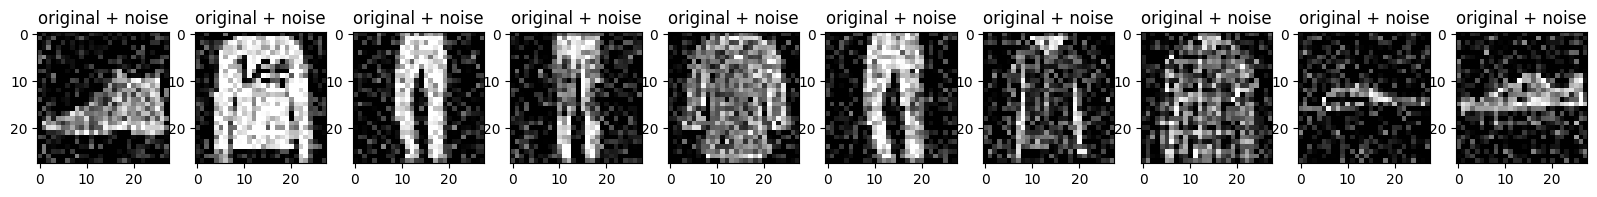

In [33]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder
### Using upsampling instead of Conv2DTranspose



In [35]:
class Denoise_v2(Model):
  def __init__(self):
    super(Denoise_v2, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), # 14, 14x 16
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)]) # 7x7x8

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'), #14x14x8
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'), #28x28x16
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')]) #28x28x1

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise_v2()

In [36]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [37]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.0152 - val_loss: 0.0104
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss:

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [40]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [41]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [42]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

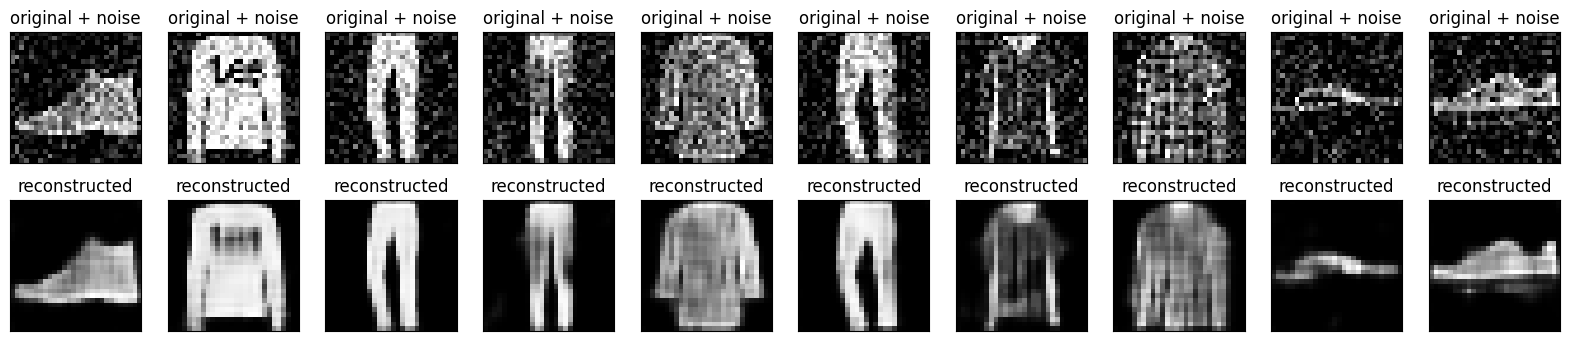

In [43]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()